In [1]:
customer_df = read.csv('Wholesale_customers_data.csv')
customer_df$Channel <- NULL
customer_df$Region <- NULL
dim(customer_df)

[1] 440   6

In [2]:
library(dplyr, warn.conflicts = FALSE)
library(moments)

In [3]:
 customer_samp_df = sample_n(customer_df, 5)

In [4]:
stats = data.frame(feature=colnames(customer_samp_df))
stats['mean_'] = sapply(customer_samp_df, mean)
stats['sd_'] = sapply(customer_samp_df, sd)
stats['skewness_'] = sapply(customer_samp_df, skewness)
stats['kurtosis_'] = sapply(customer_samp_df, kurtosis)
stats

feature,mean_,sd_,skewness_,kurtosis_
Fresh,13011.2,8159.4648,-0.06314692,1.326957
Milk,3047.8,3483.4290,1.46562068,3.202676
Grocery,3563.0,1961.1845,0.71406342,1.973512
Frozen,1319.6,611.1672,0.94479130,2.499702
Detergents_Paper,482.2,239.7096,0.15404940,1.818698
Delicatessen,1015.2,685.6673,0.29329438,1.323853


In [5]:
stats = data.frame(feature=colnames(customer_df))
stats['mean_'] = sapply(customer_df, mean)
stats['sd_'] = sapply(customer_df, sd)
stats['skewness_'] = sapply(customer_df, skewness)
stats['kurtosis_'] = sapply(customer_df, kurtosis)
stats

feature,mean_,sd_,skewness_,kurtosis_
Fresh,12000.298,12647.329,2.552583,14.39212
Milk,5796.266,7380.377,4.039922,27.37635
Grocery,7951.277,9503.163,3.575187,23.66415
Frozen,3071.932,4854.673,5.887826,57.05618
Detergents_Paper,2881.493,4767.854,3.619458,21.78053
Delicatessen,1524.870,2820.106,11.113534,171.74778


---

# MANY OF THE TOOLS WE WILL USE WILL ASSUME NORMAL DATA

---

You are already familiar with standardization.

## $$Z = \frac{X-\mu}{\sigma}$$

In [6]:
customer_sc_df = data.frame(scale(customer_df))

In [7]:
stats_sc = data.frame(feature=colnames(customer_sc_df))
stats_sc['mean_'] = sapply(customer_sc_df, mean)
stats_sc['sd_'] = sapply(customer_sc_df, sd)
stats_sc['skewness_'] = sapply(customer_sc_df, skewness)
stats_sc['kurtosis_'] = sapply(customer_sc_df, kurtosis)
stats_sc

feature,mean_,sd_,skewness_,kurtosis_
Fresh,-3.394982e-17,1,2.552583,14.39212
Milk,-4.271510e-18,1,4.039922,27.37635
Grocery,-5.480543e-17,1,3.575187,23.66415
Frozen,3.658049e-17,1,5.887826,57.05618
Detergents_Paper,3.341215e-17,1,3.619458,21.78053
Delicatessen,-4.007359e-18,1,11.113534,171.74778


In [8]:
library(ggplot2)

In [9]:
head(customer_df)

Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
12669,9656,7561,214,2674,1338
7057,9810,9568,1762,3293,1776
6353,8808,7684,2405,3516,7844
13265,1196,4221,6404,507,1788
22615,5410,7198,3915,1777,5185
9413,8259,5126,666,1795,1451


In [10]:
library(repr)
options(repr.plot.width=10, repr.plot.height=2) 

In [11]:
source('multiplot.r')

In [12]:
original_v_scaled <- function (feature) {
    original_feature <- as.vector(customer_df[[feature]])
    scaled_feature <- as.vector(customer_sc_df[[feature]])
    p1 <- qplot(original_feature, geom="histogram", bins=200, alpha=I(.4),)+
        geom_vline(aes(xintercept=mean(original_feature)), color="red", linetype="dashed", size=1)+
        geom_vline(aes(xintercept=median(original_feature)), color="blue", linetype="dashed", size=1)+
        ggtitle(paste("Original Distribution of", feature))
    p2 <- qplot(scaled_feature, geom="histogram", bins=200, alpha=I(.4),)+
        geom_vline(aes(xintercept=mean(scaled_feature)), color="red", linetype="dashed", size=1)+
        geom_vline(aes(xintercept=median(scaled_feature)), color="blue", linetype="dashed", size=1)  +
        ggtitle(paste("Scaled Distribution of", feature))  
    multiplot(p1, p2, cols=2)
}


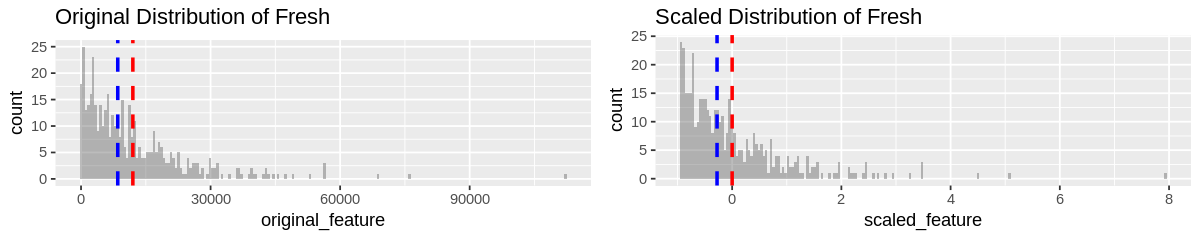

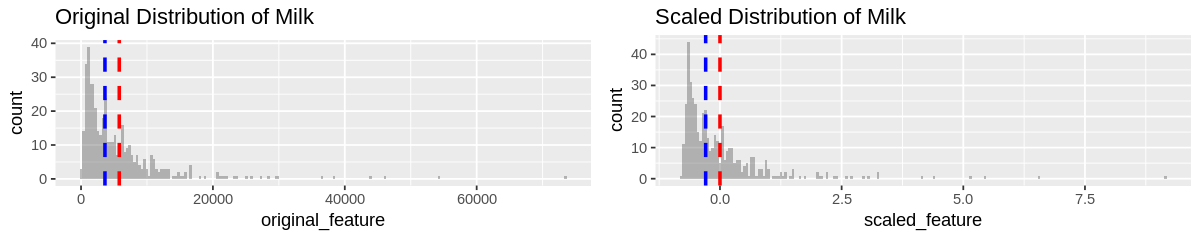

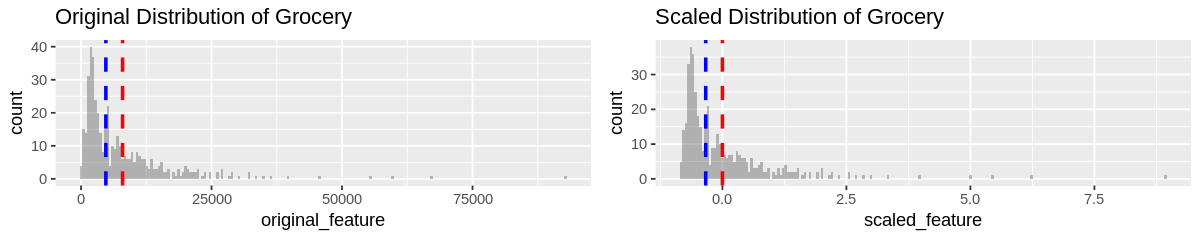

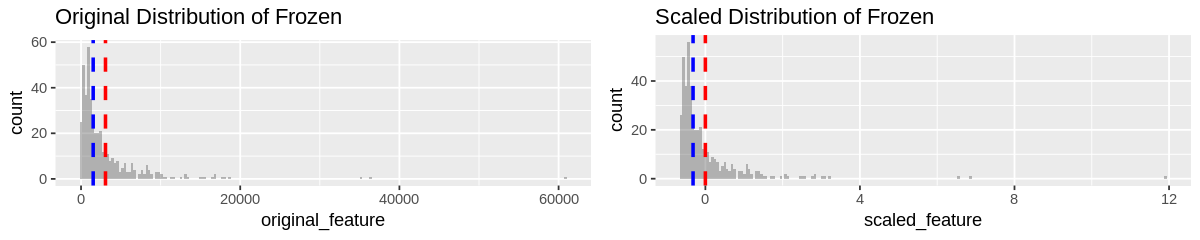

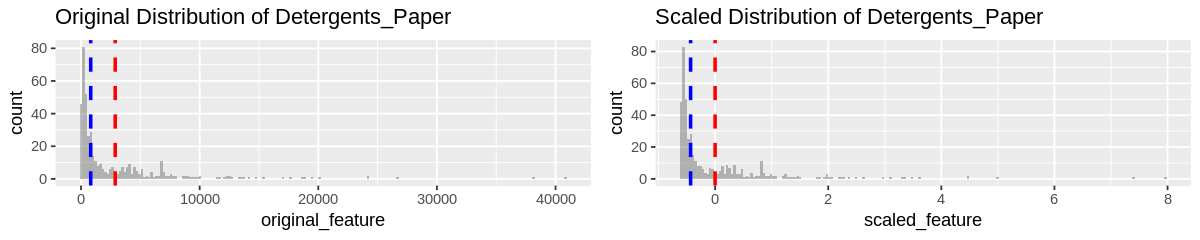

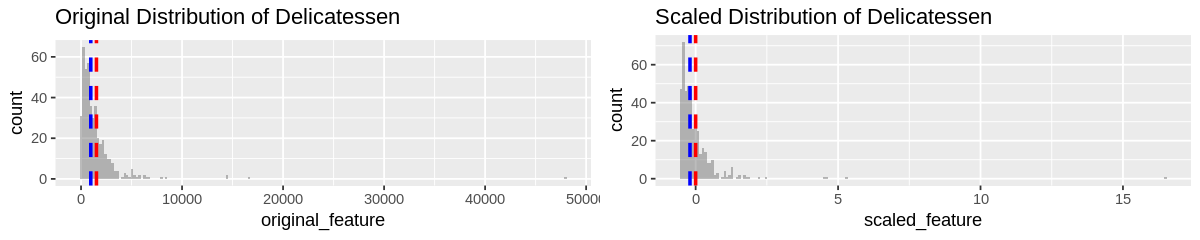

In [13]:
original_v_scaled('Fresh')
original_v_scaled('Milk')
original_v_scaled('Grocery')
original_v_scaled('Frozen')
original_v_scaled('Detergents_Paper')
original_v_scaled('Delicatessen')

## MANY OF THE TOOLS WE WILL USE WILL ASSUME NORMAL DATA

---

# Deskew the Data

We will look at two common approaches to deskewing data:

- the log transform
- scaling by the Box-Cox test

For purposes of comparison, we will keep both transforms.

We have previously looked at scaling data as a preprocessing step. Note that scaling of data will have no effect on its skewness. 

Another way we can verify this is via a test of skewness.

To perform this test we can use the `scipy.stats.skewtest`.

This function tests the null hypothesis that the skewness of the population that the sample was drawn from is the same as that of a corresponding normal distribution. Remember, a low p-value means reject the null hypothesis i.e the data is skewed!


In [14]:
skewness_ = data.frame(feature=colnames(customer_sc_df))
skewness_['skew_'] = sapply(customer_df, skewness)
skewness_['skew_sc'] = sapply(customer_sc_df, skewness)
skewness_

feature,skew_,skew_sc
Fresh,2.552583,2.552583
Milk,4.039922,4.039922
Grocery,3.575187,3.575187
Frozen,5.887826,5.887826
Detergents_Paper,3.619458,3.619458
Delicatessen,11.113534,11.113534


## Deskew by taking the log of the data

Many times the skew of data can be easily removed by taking the log of the data. Let's do so here.

We will then scale the data after deskewing.

In [15]:
customer_log_df = log(customer_df)
customer_log_sc_df = data.frame(scale(customer_log_df))

In [16]:
skewness_['skew_log_'] = sapply(customer_log_df, skewness)
skewness_['skew_log_sc'] = sapply(customer_log_sc_df, skewness)
skewness_

feature,skew_,skew_sc,skew_log_,skew_log_sc
Fresh,2.552583,2.552583,-1.6241235,-1.6241235
Milk,4.039922,4.039922,-0.2261666,-0.2261666
Grocery,3.575187,3.575187,-0.7371376,-0.7371376
Frozen,5.887826,5.887826,-0.3595744,-0.3595744
Detergents_Paper,3.619458,3.619458,-0.2712038,-0.2712038
Delicatessen,11.113534,11.113534,-1.1731543,-1.1731543


In [17]:
original_v_scaled_v_log <- function (feature) {
    original_feature <- as.vector(customer_df[[feature]])
    scaled_feature <- as.vector(customer_sc_df[[feature]])
    log_feature <- as.vector(customer_log_df[[feature]])
    log_scaled_feature <- as.vector(customer_log_sc_df[[feature]])
    p1 <- qplot(original_feature, geom="histogram", bins=200, alpha=I(.4),)+
        geom_vline(aes(xintercept=mean(original_feature)), color="red", linetype="dashed", size=1)+
        geom_vline(aes(xintercept=median(original_feature)), color="blue", linetype="dashed", size=1)+
        ggtitle(paste("Original Distribution of", feature))
    p2 <- qplot(scaled_feature, geom="histogram", bins=200, alpha=I(.4),)+
        geom_vline(aes(xintercept=mean(scaled_feature)), color="red", linetype="dashed", size=1)+
        geom_vline(aes(xintercept=median(scaled_feature)), color="blue", linetype="dashed", size=1)  +
        ggtitle(paste("Scaled Distribution of", feature))  
    p3 <- qplot(log_feature, geom="histogram", bins=200, alpha=I(.4),)+
        geom_vline(aes(xintercept=mean(log_feature)), color="red", linetype="dashed", size=1)+
        geom_vline(aes(xintercept=median(log_feature)), color="blue", linetype="dashed", size=1)+
        ggtitle(paste("Log Distribution of", feature))
    p4 <- qplot(log_scaled_feature, geom="histogram", bins=200, alpha=I(.4),)+
        geom_vline(aes(xintercept=mean(log_scaled_feature)), color="red", linetype="dashed", size=1)+
        geom_vline(aes(xintercept=median(log_scaled_feature)), color="blue", linetype="dashed", size=1)  +
        ggtitle(paste("Log Scaled Distribution of", feature))  
    multiplot(p1, p2, p3, p4, cols=4)
}



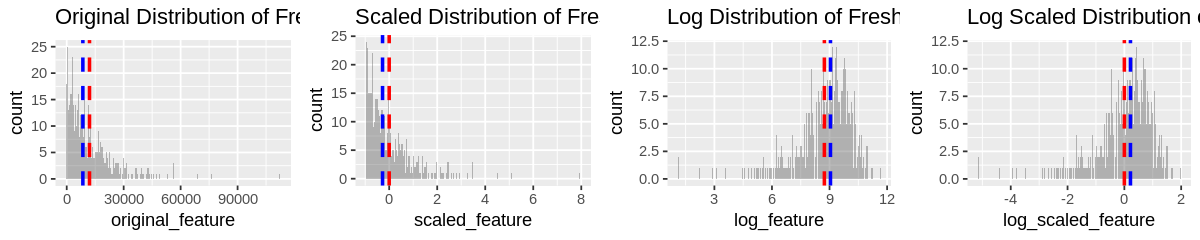

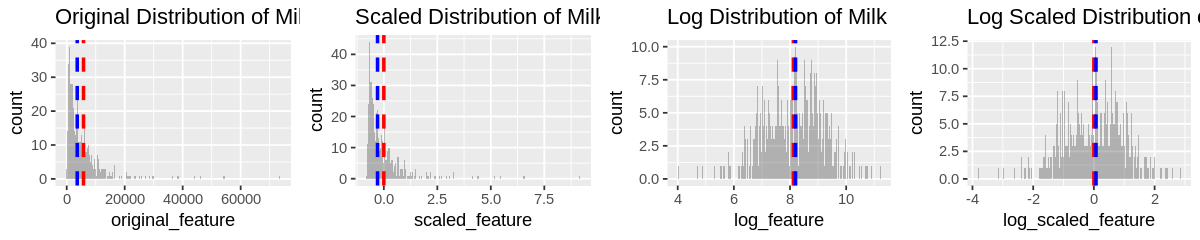

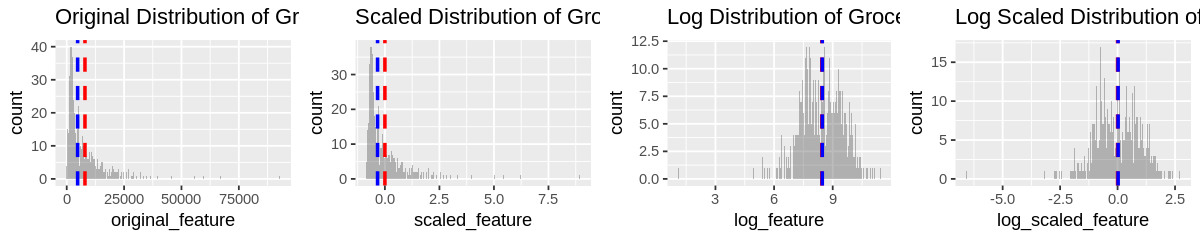

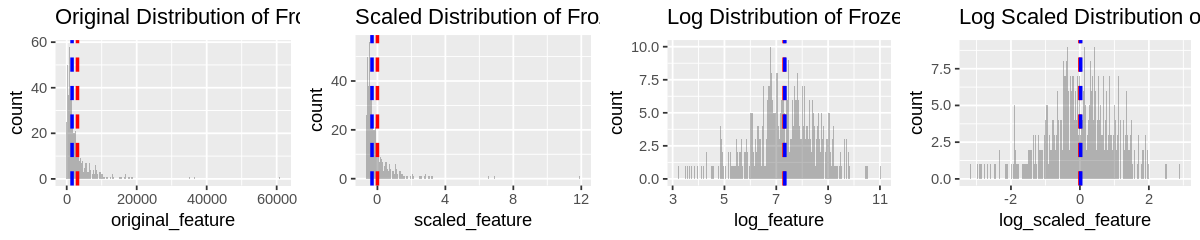

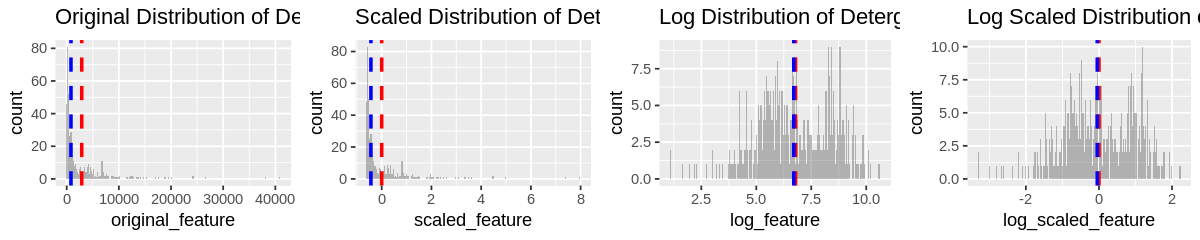

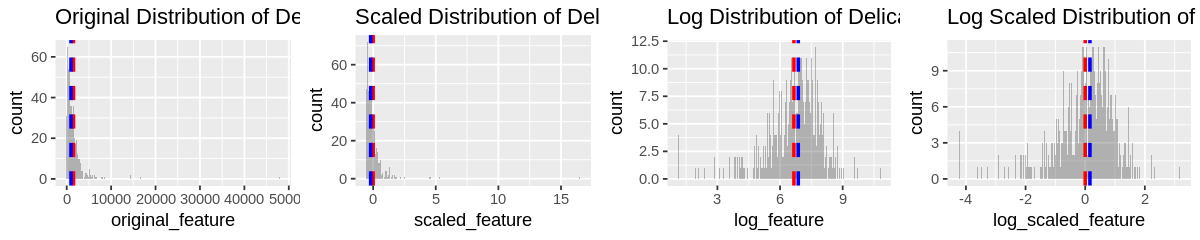

In [18]:
original_v_scaled_v_log('Fresh')
original_v_scaled_v_log('Milk')
original_v_scaled_v_log('Grocery')
original_v_scaled_v_log('Frozen')
original_v_scaled_v_log('Detergents_Paper')
original_v_scaled_v_log('Delicatessen')